### -1, Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from utils import *
from scipy.sparse.linalg import eigsh
import torch
from scipy.sparse import csr_array

### 0, Simulate some data

In [4]:
# Data simulation with a Toeplitz covariance matrix, see utils for details.
X, y, beta, Sigma = simulate_data(n=2000, d=100, rho=0.9, seed=1080)
data = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
data.rename(columns={data.shape[1]-1: 'y'}, inplace=True)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

### 1, Truncated eigendecomposition + Some plots

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                  random_state=1234)
skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_val)

# access trees
# trees = skrf.estimators_
A, metadata = make_adjacency(skrf, X_train)

A_csr = csr_array(A)
eigenvalues, eigenvectors = eigsh(A_csr, k = 1000, which = 'LM')
eigenvectors = eigenvectors[:, ::-1]
eigenvalues = eigenvalues[::-1]
eigenvalues = eigenvalues[1:]
eigenvectors = eigenvectors[:, 1:]
# exact solution
# eigenvalues, eigenvectors = np.linalg.eigh(A)
# eigenvalues = eigenvalues[::-1]
# eigenvectors = eigenvectors[::-1]

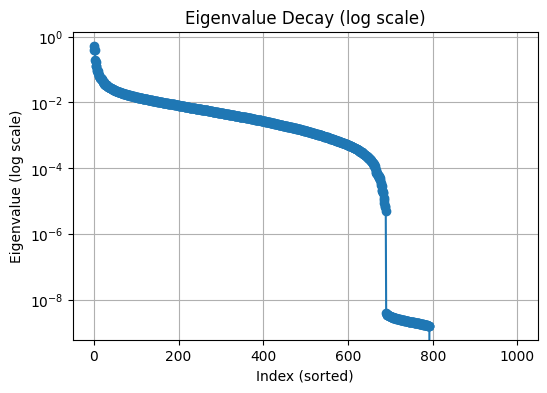

In [86]:
plt.figure(figsize=(6,4))
plt.semilogy(eigenvalues, marker='o')
plt.xlabel("Index (sorted)")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Eigenvalue Decay (log scale)")
plt.grid(True)
plt.show()

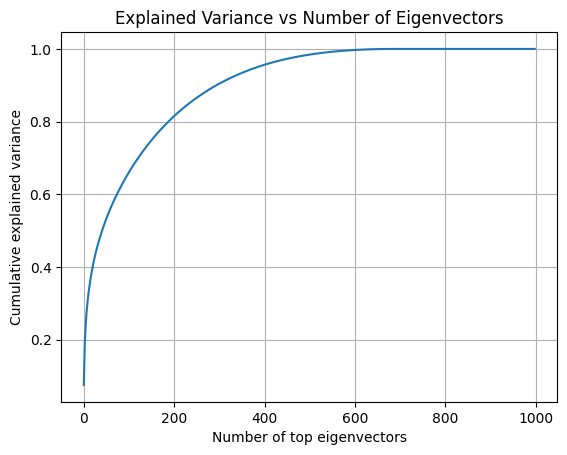

In [87]:
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
plt.plot(explained_variance)
plt.xlabel("Number of top eigenvectors")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance vs Number of Eigenvectors")
plt.grid(True)
plt.show()

### 3, Define the eigen NN function

In [104]:
class eigenNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1=256, hidden_dim2=512, use_cuda = False):
        super(eigenNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )
        self.use_cuda = use_cuda
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.to(self.device)
    def forward(self, x):
        return self.net(x)
    def train_epoch(self, train_loader, optimizer, epoch, log_interval, lambda_vec):
        self.train()
        training_loss_list = []


        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            output = self.forward(data)
            loss = torch.sum(lambda_vec * (output - target)**2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                msg = "Epoch: {:02d} | Batch {:03d} | Train Loss: {:.5f}"
                print(msg.format(epoch, batch_idx, loss.item()))
                training_loss_list.append(loss.cpu().item())
        return training_loss_list
    def validate(self, val_loader, lambda_vec):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.forward(data)
                loss = torch.sum(lambda_vec * (output - target)**2)
                total_loss += loss.item() * data.size(0)
        avg_loss = total_loss / len(val_loader.dataset)
        print(f"Validation Avg Loss: {avg_loss:.5f}")
        return avg_loss
    def run_training(self, train_loader, val_loader, optimizer, epochs, lambda_vec=None, log_interval=5):
        val_acc_list = []
        all_training_losses = []
        print(f"Training on device: {self.device}")
        if lambda_vec is not None:
            lambda_vec = lambda_vec.to(self.device)
        else:
            lambda_vec = torch.ones(self.output_dim, device=self.device, dtype=torch.float32)
        for epoch in range(epochs):
            print(f"\n-- Epoch {epoch} --")

            epoch_losses = self.train_epoch(train_loader, optimizer, epoch, log_interval, lambda_vec)
            all_training_losses.append(epoch_losses)

            avg_loss = self.validate(val_loader, lambda_vec)            
            val_acc_list.append(avg_loss)

        print('\n Training Complete.')
        return all_training_losses, val_acc_list

In [105]:
M = 400
input_dim = 100
output_dim = M
lr = 1e-3
batch_size = 64
epochs = 20
use_cuda = True
# Inspection
# Select your values for M here.
lambda_M = eigenvalues[:M]
psi_M = eigenvectors[:, :M].copy()
train_dataset = TabularDataset(X_train, psi_M)


# Nystrom KPCA to make new validation set
lambda_inv = np.diag(1.0/np.sqrt(lambda_M))
A_new = new_adjacency(skrf, X_val, metadata)
psi_val = (lambda_inv @ psi_M.T @ A_new.T).T
val_dataset = TabularDataset(X_val, psi_val)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)
# Weigh the coefficients
lambda_vec = torch.exp(-0.5 * torch.arange(M, dtype=torch.float32))
lambda_vec /= lambda_vec.sum()

In [90]:
print(psi_M.shape)
print(psi_val.shape)

(1440, 400)
(160, 400)


In [91]:
tree = eigenNN(input_dim=input_dim, output_dim=output_dim, use_cuda=use_cuda)
optimizer = torch.optim.Adam(tree.parameters(), lr=lr)

training_losses, validation_losses = tree.run_training(
    train_loader, 
    val_loader, 
    optimizer, 
    epochs, 
    lambda_vec
)

Training on device: cpu

-- Epoch 0 --
Epoch: 00 | Batch 000 | Train Loss: 0.12833
Epoch: 00 | Batch 005 | Train Loss: 0.12458
Epoch: 00 | Batch 010 | Train Loss: 0.03702
Epoch: 00 | Batch 015 | Train Loss: 0.02591
Epoch: 00 | Batch 020 | Train Loss: 0.02367
Validation Avg Loss: 0.01188

-- Epoch 1 --
Epoch: 01 | Batch 000 | Train Loss: 0.02029
Epoch: 01 | Batch 005 | Train Loss: 0.01325
Epoch: 01 | Batch 010 | Train Loss: 0.01156
Epoch: 01 | Batch 015 | Train Loss: 0.01228
Epoch: 01 | Batch 020 | Train Loss: 0.01032
Validation Avg Loss: 0.00938

-- Epoch 2 --
Epoch: 02 | Batch 000 | Train Loss: 0.00952
Epoch: 02 | Batch 005 | Train Loss: 0.00781
Epoch: 02 | Batch 010 | Train Loss: 0.00756
Epoch: 02 | Batch 015 | Train Loss: 0.00742
Epoch: 02 | Batch 020 | Train Loss: 0.00725
Validation Avg Loss: 0.00804

-- Epoch 3 --
Epoch: 03 | Batch 000 | Train Loss: 0.00581
Epoch: 03 | Batch 005 | Train Loss: 0.00525
Epoch: 03 | Batch 010 | Train Loss: 0.00482
Epoch: 03 | Batch 015 | Train Loss: 0

In [92]:
c = psi_M @ np.diag(lambda_M)
with torch.no_grad():
    output = tree(torch.tensor(X_test.values, dtype=torch.float32)).T
results = (c @ output.numpy()).T @ y_train
results[results > 0] = 1
results[results < 0] = 0
accuracy_score(results, y_test)

0.7925

### 4, New Idea 2: Decision Tree???

In [93]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [94]:
DTR = DecisionTreeRegressor(random_state=0, max_depth=5)
DTR.fit(X_train, psi_M)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [95]:
output = DTR.predict(X_test).T
results = (c @ output).T @ y_train
results[results > 0] = 1
results[results < 0] = 0
accuracy_score(results, y_test)

0.6675

Seems like a fun and reasonable baseline

In [106]:
M = 2
input_dim = 100
output_dim = M
lr = 1e-3
batch_size = 64
epochs = 20
use_cuda = True
rf_preds = skrf.predict_proba(X_train)
train_dataset = TabularDataset(X_train, rf_preds)

rf_preds_val = skrf.predict_proba(X_val)
val_dataset = TabularDataset(X_val, rf_preds_val)

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)

In [108]:
tree = eigenNN(input_dim=input_dim, output_dim=output_dim, use_cuda=use_cuda)
optimizer = torch.optim.Adam(tree.parameters(), lr=lr)

training_losses, validation_losses = tree.run_training(
    train_loader, 
    val_loader, 
    optimizer, 
    epochs
)

Training on device: cpu

-- Epoch 0 --
Epoch: 00 | Batch 000 | Train Loss: 42.17010
Epoch: 00 | Batch 005 | Train Loss: 2.86848
Epoch: 00 | Batch 010 | Train Loss: 4.49712
Epoch: 00 | Batch 015 | Train Loss: 3.64439
Epoch: 00 | Batch 020 | Train Loss: 2.07442
Validation Avg Loss: 1.88521

-- Epoch 1 --
Epoch: 01 | Batch 000 | Train Loss: 2.63216
Epoch: 01 | Batch 005 | Train Loss: 1.46529
Epoch: 01 | Batch 010 | Train Loss: 1.76664
Epoch: 01 | Batch 015 | Train Loss: 1.37127
Epoch: 01 | Batch 020 | Train Loss: 1.14179
Validation Avg Loss: 1.06981

-- Epoch 2 --
Epoch: 02 | Batch 000 | Train Loss: 1.13436
Epoch: 02 | Batch 005 | Train Loss: 0.94617
Epoch: 02 | Batch 010 | Train Loss: 0.96351
Epoch: 02 | Batch 015 | Train Loss: 0.65595
Epoch: 02 | Batch 020 | Train Loss: 0.76087
Validation Avg Loss: 0.79104

-- Epoch 3 --
Epoch: 03 | Batch 000 | Train Loss: 0.74053
Epoch: 03 | Batch 005 | Train Loss: 0.80741
Epoch: 03 | Batch 010 | Train Loss: 0.77531
Epoch: 03 | Batch 015 | Train Loss: 

In [ ]:
with torch.no_grad():
    output = tree(torch.tensor(X_test.values, dtype=torch.float32)).numpy()

In [116]:
results = np.argmax(output, axis = 0)